In [110]:
"""Project 2, Questions 1-5"""

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (ConfusionMatrixDisplay, log_loss, roc_auc_score, recall_score, 
precision_score, average_precision_score, f1_score, classification_report, 
accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix)
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None # default = 'warn'

__author__ = "Kyle Riggs"
__version__ = "Fall 2022"

### 1. Problem Statement
#### Describe the dataset, analyze the target variable, and state your prediction goal.

Link: https://www.kaggle.com/datasets/imohtn/video-games-rating-by-esrb  

ESRB, or the Entertainment Software Rating Board, rates games with a score of E for everyone, ET for ages 10+, T for teen or ages 13+, and M for mature or ages 17+ based on the features of the game, with considerations for alcohol/drug references and usage, strong language, violence, and sexual content, among other things.  

This data source is a collection of 1895 video games, along with the console they released on, their ESRB rating, and a binary vector for the features ESRB used to rate the game.  

The target variable is the ESRB Rating, which can be any of the 4 above-mentioned values: E, ET, T, M.  

The goal is to be able to predict which rating a game should be given based on the features it contains with at least 80% accuracy.

In [95]:
df = pd.read_csv("Video_games_esrb_rating.csv")
print("Shape:", df.shape)
df.head(5)

Shape: (1895, 34)


,title,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,...,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,Monster Jam Steel Titans 2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
1,Subnautica: Below Zero,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ET
2,NIER REPLICANT VER.1.22474487139…,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,M
3,Jamestown+,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,ET
4,Neptunia Virtual Stars,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,T


### 2. Basic Data Cleaning

#### Remove duplicates.
This step will be completed before dropping unwanted features, as one of the unwanted features is a determinant for uniqueness.  
There are no duplicates, so nothing needs to be removed, however.

In [96]:
df["title"].is_unique

True

#### Drop unwanted features.

Title and console are not relevant to the rating, and thus shall be removed.

In [97]:
df.drop(columns=["title", "console"], axis=1, inplace=True)
df.head(5)

,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,intense_violence,language,...,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,ET
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,M
3,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,ET
4,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,T


#### Address missing values.
There are no missing values.

In [98]:
df.isnull().sum(axis=0)

alcohol_reference           0
animated_blood              0
blood                       0
blood_and_gore              0
cartoon_violence            0
crude_humor                 0
drug_reference              0
fantasy_violence            0
intense_violence            0
language                    0
lyrics                      0
mature_humor                0
mild_blood                  0
mild_cartoon_violence       0
mild_fantasy_violence       0
mild_language               0
mild_lyrics                 0
mild_suggestive_themes      0
mild_violence               0
no_descriptors              0
nudity                      0
partial_nudity              0
sexual_content              0
sexual_themes               0
simulated_gambling          0
strong_janguage             0
strong_sexual_content       0
suggestive_themes           0
use_of_alcohol              0
use_of_drugs_and_alcohol    0
violence                    0
esrb_rating                 0
dtype: int64

#### Correct a small error in the data.
The column 'strong_janguage' should instead be 'strong_language'.

In [99]:
df = df.rename(columns={"strong_janguage": "strong_language"})

#### Check if there are any inconsistent inputs for categorical variables.
There are only the expected binary inputs for all variables except the target, for which there are only the expected values of E, ET, T, and M.

In [100]:
for column in df:
    print(df[column].value_counts())

0    1800
1      95
Name: alcohol_reference, dtype: int64
0    1876
1      19
Name: animated_blood, dtype: int64
0    1463
1     432
Name: blood, dtype: int64
0    1656
1     239
Name: blood_and_gore, dtype: int64
0    1858
1      37
Name: cartoon_violence, dtype: int64
0    1792
1     103
Name: crude_humor, dtype: int64
0    1829
1      66
Name: drug_reference, dtype: int64
0    1477
1     418
Name: fantasy_violence, dtype: int64
0    1671
1     224
Name: intense_violence, dtype: int64
0    1690
1     205
Name: language, dtype: int64
0    1832
1      63
Name: lyrics, dtype: int64
0    1873
1      22
Name: mature_humor, dtype: int64
0    1763
1     132
Name: mild_blood, dtype: int64
0    1850
1      45
Name: mild_cartoon_violence, dtype: int64
0    1804
1      91
Name: mild_fantasy_violence, dtype: int64
0    1854
1      41
Name: mild_language, dtype: int64
0    1749
1     146
Name: mild_lyrics, dtype: int64
0    1811
1      84
Name: mild_suggestive_themes, dtype: int64
0    1805
1    

#### Transform categorical variables into numeric.
All categorical variables are already binary.

#### Use boxplots or histograms to identify outliers for numeric variables and remove them.
There are no numerical variables, and thus there are no outliers to remove.

### 3.1 Feature Engineering: Feature Selection

#### Use graphs, ANOVA test, Chi-squared test to reduce the dimension.
Since every remaining feature is categorical (binary), I will be using chi-squared test.  

As there is only a single feature with a p-value greater than 0.05, which if dropped would leave 30 remaining features, I will instead drop all but the top 10 features.

In [101]:
pre_x = df.drop(['esrb_rating'], axis = 1)
y = df.loc[:, 'esrb_rating']

fs = SelectKBest(score_func=chi2, k=10)
features = fs.fit(pre_x, y)

x = pre_x.iloc[:, fs.get_support()]
x

,blood,blood_and_gore,fantasy_violence,intense_violence,mild_fantasy_violence,no_descriptors,sexual_themes,strong_language,strong_sexual_content,suggestive_themes
0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,1
3,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1890,0,0,1,0,0,0,1,1,0,0
1891,0,0,1,0,0,0,0,0,0,0
1892,0,0,0,0,0,1,0,0,0,0
1893,1,0,0,0,0,0,0,0,0,0


#### Are there any features with high correlation to one another?
Function Source: https://stackoverflow.com/questions/61146233/how-to-use-sklearn-chi-square-or-anova-to-removes-redundant-features  

The highest correlation between any 2 features is only ~0.386, thus no features will be removed due to high correlation.

In [102]:
def get_feature_correlation(df, top_n=None, corr_method='spearman',
                            remove_duplicates=True, remove_self_correlations=True):
    """
    Compute the feature correlation and sort feature pairs based on their correlation

    :param df: The dataframe with the predictor variables
    :type df: pandas.core.frame.DataFrame
    :param top_n: Top N feature pairs to be reported (if None, all of the pairs will be returned)
    :param corr_method: Correlation compuation method
    :type corr_method: str
    :param remove_duplicates: Indicates whether duplicate features must be removed
    :type remove_duplicates: bool
    :param remove_self_correlations: Indicates whether self correlations will be removed
    :type remove_self_correlations: bool

    :return: pandas.core.frame.DataFrame
    """
    corr_matrix_abs = df.corr(method=corr_method).abs()
    corr_matrix_abs_us = corr_matrix_abs.unstack()
    sorted_correlated_features = corr_matrix_abs_us \
        .sort_values(kind="quicksort", ascending=False) \
        .reset_index()

    # Remove comparisons of the same feature
    if remove_self_correlations:
        sorted_correlated_features = sorted_correlated_features[
            (sorted_correlated_features.level_0 != sorted_correlated_features.level_1)
        ]

    # Remove duplicates
    if remove_duplicates:
        sorted_correlated_features = sorted_correlated_features.iloc[:-2:2]

    # Create meaningful names for the columns
    sorted_correlated_features.columns = ['Feature 1', 'Feature 2', 'Correlation (abs)'] 

    if top_n:
        return sorted_correlated_features[:top_n]

    return sorted_correlated_features

get_feature_correlation(x)

,Feature 1,Feature 2,Correlation (abs)
10,strong_sexual_content,intense_violence,0.386323
12,strong_sexual_content,blood_and_gore,0.336910
14,strong_language,blood,0.291957
16,intense_violence,blood_and_gore,0.289246
18,strong_language,sexual_themes,0.274595
20,no_descriptors,fantasy_violence,0.223748
22,strong_language,blood_and_gore,0.220318
24,blood_and_gore,blood,0.206437
26,blood,no_descriptors,0.185570
28,blood,fantasy_violence,0.173801


### 3.2 Feature Engineering: Feature Scaling

#### Does this algorithm require normalized data or standardized data?
The data does not need normalization or standardization because all features are binary categorical.

#### Are there any categorical variables that need to be changed to dummy variables?
All categorical variables are binary, and thus do not need to be changed to dummy variables.

### 4. Build the Prediction Model

#### Do you use train_test_split or cross validation to validate the result?
I use train_test_split.

In [103]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=0, stratify = y)

#### Does this data need to be balanced?
Yes, as T accounts for 36% of all data, which is above the expected 25% for 4 possible results.

In [104]:
os = SMOTE(random_state=0)
oversampled_x, oversampled_y = os.fit_resample(x_train, y_train)
print(x_train.shape)
print(oversampled_x.shape)

(1516, 10)
(2204, 10)


#### Which algorithm is appropriate for this problem?
I will be using DecisionTreeClassifier, as it is simple and easier to interpret and understand than a Random Forest.

In [105]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf.fit(oversampled_x, oversampled_y)
clf.score(x_test, y_test)

0.6437994722955145

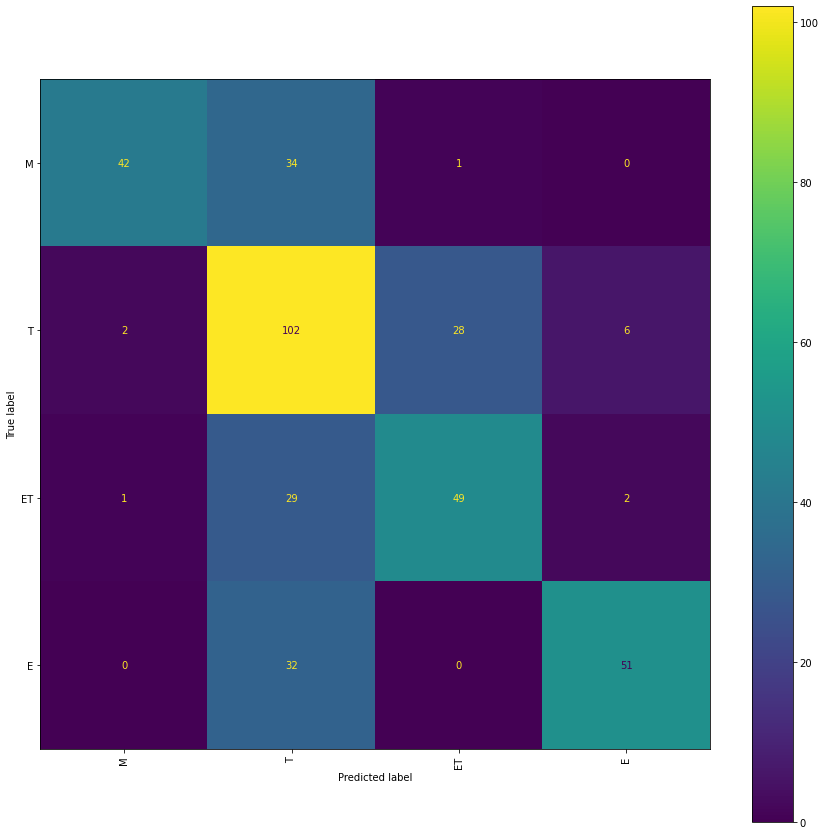

In [113]:
test_pred = clf.predict(x_test)
fig, ax = plt.subplots(figsize=(15,15))

labels = ['M', 'T', 'ET', 'E']
metrics.plot_confusion_matrix(clf, x_test, y_test, labels=labels, xticks_rotation='vertical', ax=ax)

#### Which metrics do you use to evaluate the prediction model?
Accuracy, of which the value is 0.64.  
The most important thing to predict is that a game that should be rated M for mature is not rated below M. This model rates only 35 M-rated games below M, and of those, 34 of them were predicted to be T-rated.  
The model predicts T-rated games incorrectly the most frequently, but with the knowledge that T-rated games are often nebulously rated between M- and ET-rated games in the real world and tend to have the most wide range of features, this makes sense.

THIS IS AN INDIVIDUAL ASSIGNMENT. YOU MAY NOT DISCUSS THIS ASSIGNMENT WITH ANYONE WITHIN OR OUTSIDE THE CLASS (except the instructor).
- DO not discuss your approaches or your code with colleagues. There are many ways to implement this assignment, and it is extremely easy to spot code that has been inspired by someone else’s code and to identify unauthorized collaborations.
- If you choose to utilize something you find online, cite that resource, but DO NOT share that resource with anyone else.
By submitting this assignment, you certify that no unauthorized assistance has been received or given in the completion of this work.
 
Kyle Riggs